In [1]:
# !pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI


In [2]:
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate, get_iou_types
from utils.plot import plot_losses, plot_ap_ars
from utils.save import get_data_from_metric_logger
from utils.coco_utils import get_cocos

from models.setup import ModelSetup
from models.build import create_multimodal_rcnn_model
from models.train import TrainingInfo
from utils.save import check_best, end_train
from data.load import get_datasets, get_dataloaders
from IPython.display import clear_output
from utils.eval import get_ap_ar, get_ap_ar_for_train_val
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup
from utils.init import reproducibility, clean_memory_get_device
from models.dynamic_loss import DynamicWeightedLoss
from data.constants import DEFAULT_REFLACX_LABEL_COLS, XAMI_MIMIC_PATH
from  datetime import datetime
import torch.optim as optim

## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [3]:
device = clean_memory_get_device()
reproducibility()


This notebook will running on device: [CUDA]


In [4]:
use_iobb = True
io_type_str = "IoBB" if use_iobb else "IoU"
labels_cols = DEFAULT_REFLACX_LABEL_COLS
iou_thrs = np.array([0.5])

common_args = {
    "save_early_stop_model": True,
    "optimiser": "sgd",
    "lr": 1e-3,
    "weight_decay": 1e-5,
    "image_backbone_pretrained": True,
    "fixation_backbone_pretrained": True,
    "record_training_performance": True,
    "image_size": 512,
    "batch_size": 4,
    "warmup_epochs": 0,
    "lr_scheduler": "ReduceLROnPlateau",
    "reduceLROnPlateau_factor": 0.1,
    "reduceLROnPlateau_patience": 999,
    "reduceLROnPlateau_full_stop": True,
    "multiStepLR_milestones": 100,
    "multiStepLR_gamma": 0.1,
    "use_mask": True,
    "gt_in_train_till": 999,
    "box_head_dropout_rate": 0,
    "measure_test": True,
}

fusion_add_args = {
    "fuse_depth": 0,
    "fusion_residule": False,
    "fusion_strategy": "add", 
}

small_model_args = {
    "mask_hidden_layers": 64,
    "fuse_conv_channels": 64,
    "representation_size": 64, 
    "backbone_out_channels": 64,
}

mobilenet_args = {
    "backbone": "mobilenet_v3",
    "using_fpn": False,
}

In [5]:
all_model_setups = [
    ModelSetup(
        name="forward_testing_model",
        use_fixations=True,
        **mobilenet_args,
        **small_model_args,
        **common_args,
        **fusion_add_args,
    )
]

In [6]:
num_epochs = 1
train_infos = []

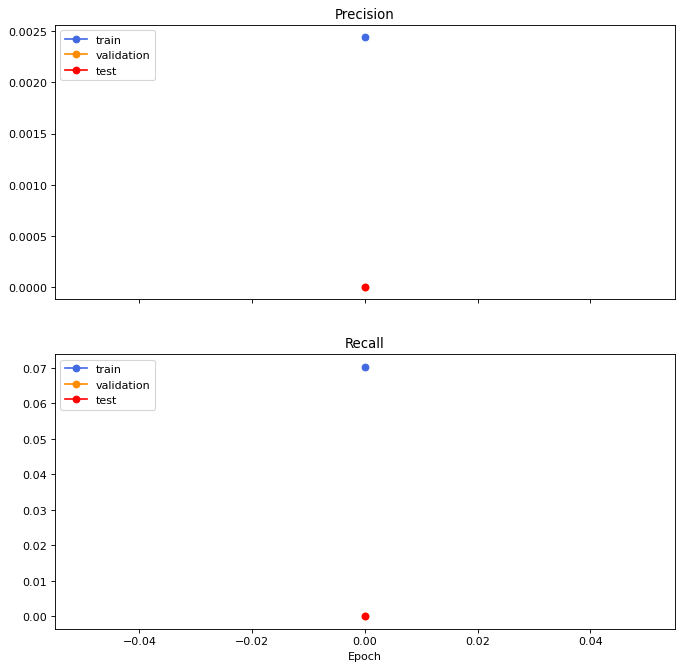

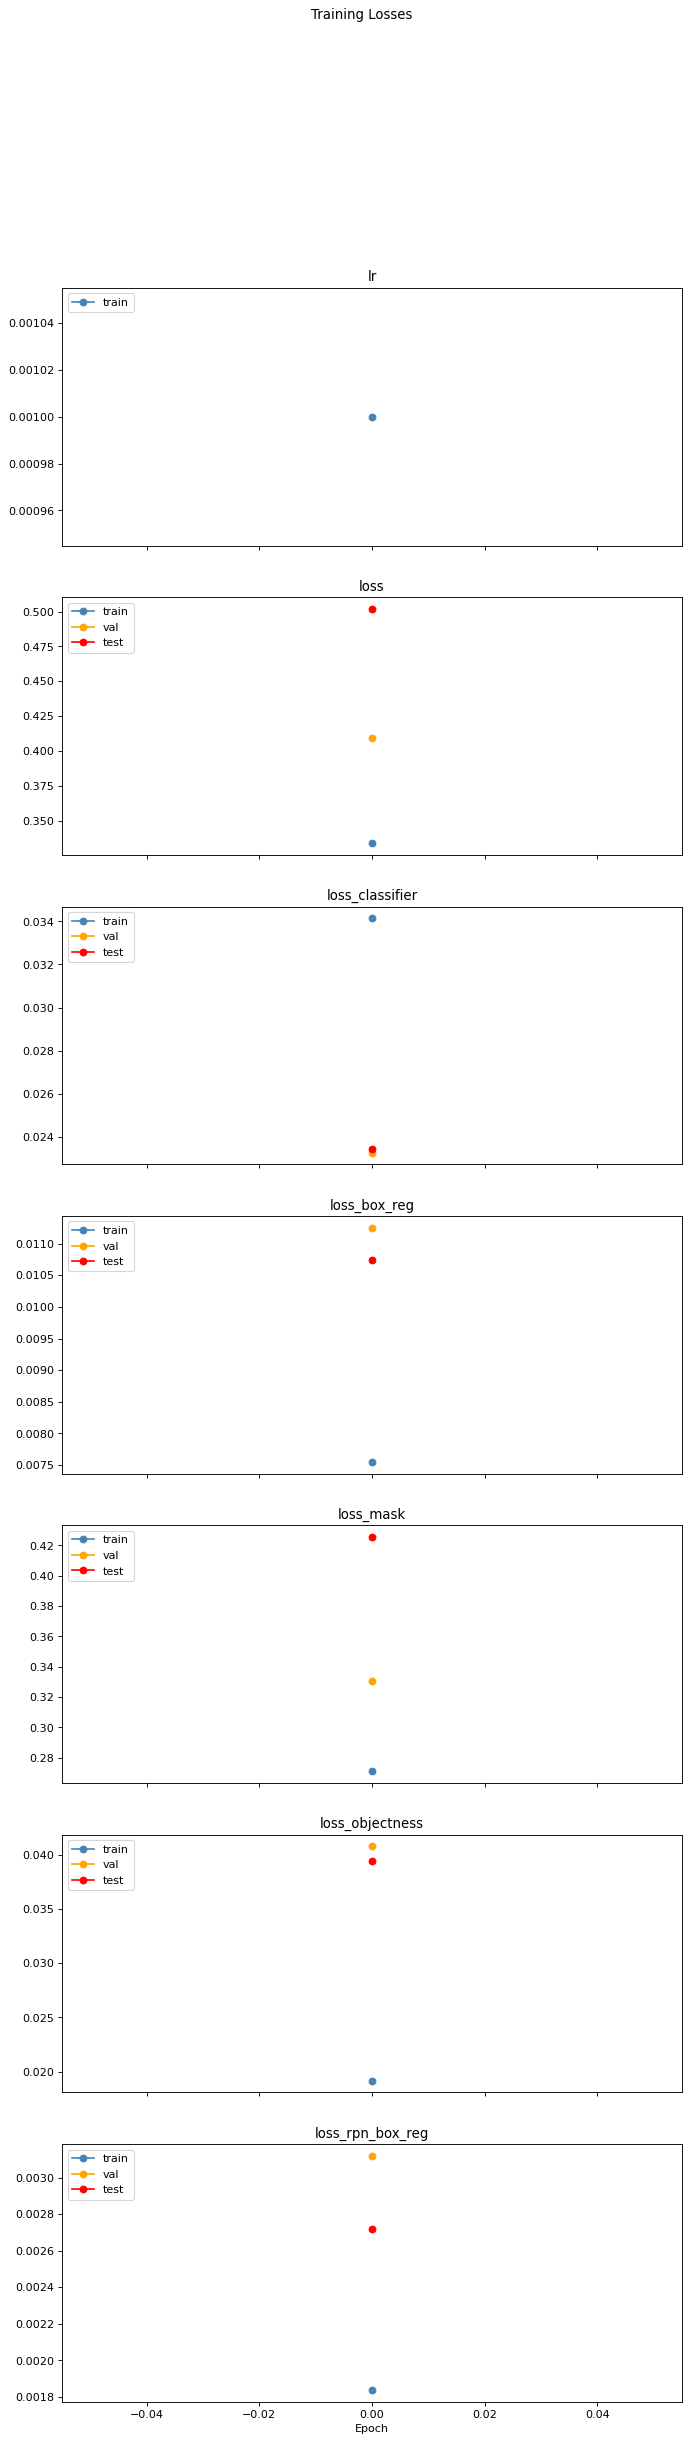

====================| Epoch [1] Done | It has took [23.78] min, Avg time: [1427.00] sec/epoch | Estimate time for [1] epochs: [23.78] min | Epoch took [1427] sec | Patience [0] |====================
Evaluation:  [  0/114]  eta: 0:02:51  loss: 0.0636 (0.0636)  loss_classifier: 0.0020 (0.0020)  loss_box_reg: 0.0000 (0.0000)  loss_mask: 0.0000 (0.0000)  loss_objectness: 0.0548 (0.0548)  loss_rpn_box_reg: 0.0068 (0.0068)  model_time: 0.1620 (0.1620)  evaluator_time: 0.0020 (0.0020)  time: 1.5033  data: 1.1253  max mem: 2403
Evaluation:  [100/114]  eta: 0:00:18  loss: 0.5316 (0.4156)  loss_classifier: 0.0209 (0.0219)  loss_box_reg: 0.0108 (0.0102)  loss_mask: 0.3847 (0.3445)  loss_objectness: 0.0309 (0.0363)  loss_rpn_box_reg: 0.0026 (0.0027)  model_time: 0.0520 (0.0544)  evaluator_time: 0.0010 (0.0012)  time: 1.2934  data: 1.1263  max mem: 2403
Evaluation:  [113/114]  eta: 0:00:01  loss: 0.3753 (0.4200)  loss_classifier: 0.0171 (0.0217)  loss_box_reg: 0.0085 (0.0100)  loss_mask: 0.3170 (0.

In [7]:
## we have to mention that in order to provide objective evaluation, we compromise the dataset size, which also nagatively afftect the performance and generlaization.

for model_setup in all_model_setups:

    print_f.print_title("Preparing for the training.")

    train_info = TrainingInfo(model_setup)

    if model_setup.measure_test:
        # initialise the test recording list.
        train_info.test_ap_ars = []

    model = create_multimodal_rcnn_model(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    model.to(device)

    ################ Datasets ################
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_fixation": model_setup.use_fixations,
        "bbox_to_mask": model_setup.use_mask,
        "labels_cols": labels_cols,
    }

    print("Dataloader creating...")

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict,
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=model_setup.batch_size,
    )

    print("Dataloader created!!")

    # train_coco= None

    train_coco, val_coco, test_coco = get_cocos(
        train_dataloader, val_dataloader, test_dataloader
    )

    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )

    # dynamic_loss_weight = None
    loss_keys = [
        "loss_classifier",
        "loss_box_reg",
        "loss_objectness",
        "loss_rpn_box_reg",
    ]
    
    dynamic_loss_weight = DynamicWeightedLoss(
        keys=loss_keys + ["loss_mask"] if model_setup.use_mask else loss_keys
    )
    dynamic_loss_weight.to(device)
    print_params_setup(model)

    params = [p for p in model.parameters() if p.requires_grad]
    if dynamic_loss_weight:
        params += [p for p in dynamic_loss_weight.parameters() if p.requires_grad]

    iou_types = get_iou_types(model, model_setup)
    optimizer = get_optimiser(params, model_setup)
    lr_scheduler = get_lr_scheduler(optimizer, model_setup)

    current_time = datetime.now()

    print_f.print_title(
        f"Start training. Preparing Tooke [{ (current_time - train_info.start_t).seconds}] sec"
    )

    train_info.start_t = datetime.now()

    val_loss = None

    ## Start the training from here.
    for e in range(num_epochs):

        print_f.print_title(f"Training model: [{model_setup.name}]")
        print(train_info)

        train_info.epoch = e + 1

        if train_info.epoch > model_setup.gt_in_train_till:
            model.roi_heads.use_gt_in_train  = False

        ###### Perform training and show the training result here ######
        model.train()

        train_info.last_train_evaluator, train_loger = xami_train_one_epoch(
            model=model,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            epoch=train_info.epoch,
            print_freq=10,
            iou_types=iou_types,
            coco=train_coco,
            score_thres=None,
            evaluate_on_run=True,
            params_dict=eval_params_dict,
            dynamic_loss_weight=dynamic_loss_weight,
        )

        # train_info.train_evaluators.append(train_evaluator)
        train_info.train_losses.append(get_data_from_metric_logger(train_loger))
        ################################################################

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        train_info.last_val_evaluator, val_logger = xami_evaluate(
            model=model,
            data_loader=val_dataloader,
            device=device,
            params_dict=eval_params_dict,
            coco=val_coco,
            iou_types=iou_types,
            score_thres=None,
        )

        # train_info.val_evaluators.append(val_evaluator)
        train_info.val_losses.append(get_data_from_metric_logger(val_logger))

        train_ap_ar, val_ap_ar = get_ap_ar_for_train_val(
            train_info.last_train_evaluator,
            train_info.last_val_evaluator,
            areaRng="all",
            iouThr=0.5,
            maxDets=10,
        )

        train_info.train_ap_ars.append(train_ap_ar)
        train_info.val_ap_ars.append(val_ap_ar)

        if model_setup.measure_test:
            train_info.test_evaluator, test_logger = xami_evaluate(
                model=model,
                data_loader=test_dataloader,
                device=device,
                params_dict=eval_params_dict,
                coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
            )
            train_info.test_losses.append(get_data_from_metric_logger(test_logger))
            test_ap_ar = get_ap_ar(
                train_info.test_evaluator, areaRng="all", iouThr=0.5, maxDets=10,
            )
            train_info.test_ap_ars.append(test_ap_ar)

        ### update the learning rate

        val_loss = train_info.val_losses[-1]["loss"]

        if train_info.epoch > model_setup.warmup_epochs:
            if not lr_scheduler is None:
                if isinstance(lr_scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    if (
                        model_setup.reduceLROnPlateau_full_stop
                        and lr_scheduler.num_bad_epochs
                        >= model_setup.reduceLROnPlateau_patience
                    ):
                        print_f.print_title(
                            f"| EarlyStop | Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec |"
                        )
                        break
                    lr_scheduler.step(val_loss)
                else:
                    lr_scheduler.step()

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        # if model_setup.record_training_performance:
        plot_ap_ars(
            train_ap_ars=train_info.train_ap_ars,
            val_ap_ars=train_info.val_ap_ars,
            test_ap_ars=train_info.test_ap_ars,
        )

        plot_losses(train_info.train_losses, train_info.val_losses, test_logers=train_info.test_losses)

        previous_time = current_time
        current_time = datetime.now()
        epoch_took = current_time - previous_time

        sec_took = (current_time - train_info.start_t).seconds
        speed = sec_took / train_info.epoch

        print_str = f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs}] epochs: [{speed*num_epochs/60:.2f}] min | Epoch took [{epoch_took.seconds}] sec | "

        if lr_scheduler and hasattr(lr_scheduler, "num_bad_epochs"):
            print_str += f"Patience [{lr_scheduler.num_bad_epochs}] |"

        print_f.print_title(print_str)

        #######################################################################################
        if model_setup.save_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                val_ap_ar=val_ap_ar,
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
                test_coco=test_coco,
                iou_types=iou_types,
                score_thres=None,
                dynamic_weight=dynamic_loss_weight,
            )

    val_ap_ar = get_ap_ar(train_info.last_val_evaluator)

    train_info = end_train(
        train_info=train_info,
        model=model,
        optim=optimizer,
        eval_params_dict=eval_params_dict,
        last_val_ar=val_ap_ar["ar"],
        last_val_ap=val_ap_ar["ap"],
        test_dataloader=test_dataloader,
        device=device,
        test_coco=test_coco,
        iou_types=iou_types,
        score_thres=None,
        dynamic_weight=dynamic_loss_weight,
    )

    train_infos.append(train_info)


========================================For Training [forward_testing_model]========================================
ModelSetup(name='forward_testing_model', use_fixations=True, save_early_stop_model=True, record_training_performance=True, backbone='mobilenet_v3', optimiser='sgd', lr=0.001, weight_decay=1e-05, image_backbone_pretrained=True, fixation_backbone_pretrained=True, image_size=512, backbone_out_channels=64, batch_size=4, warmup_epochs=0, lr_scheduler='ReduceLROnPlateau', reduceLROnPlateau_factor=0.1, reduceLROnPlateau_patience=999, reduceLROnPlateau_full_stop=True, multiStepLR_milestones=100, multiStepLR_gamma=0.1, representation_size=64, mask_hidden_layers=64, using_fpn=False, use_mask=True, fuse_conv_channels=64, box_head_dropout_rate=0, fuse_depth=0, fusion_strategy='add', fusion_residule=False, gt_in_train_till=999, measure_test=True)

Best AP validation model has been saved to: [val_ar_0_0000_ap_0_0000_test_ar_0_0000_ap_0_0000_epoch1_08-16-2022 20-26-19_forward_testing_m

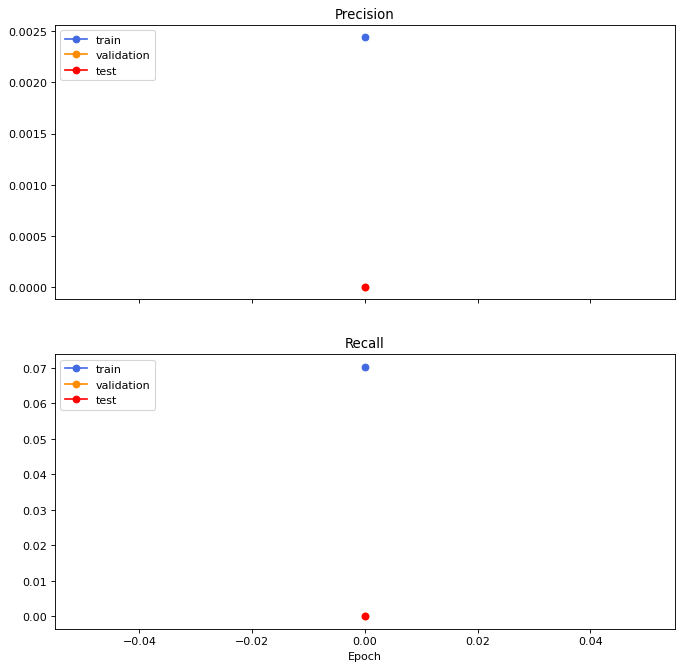

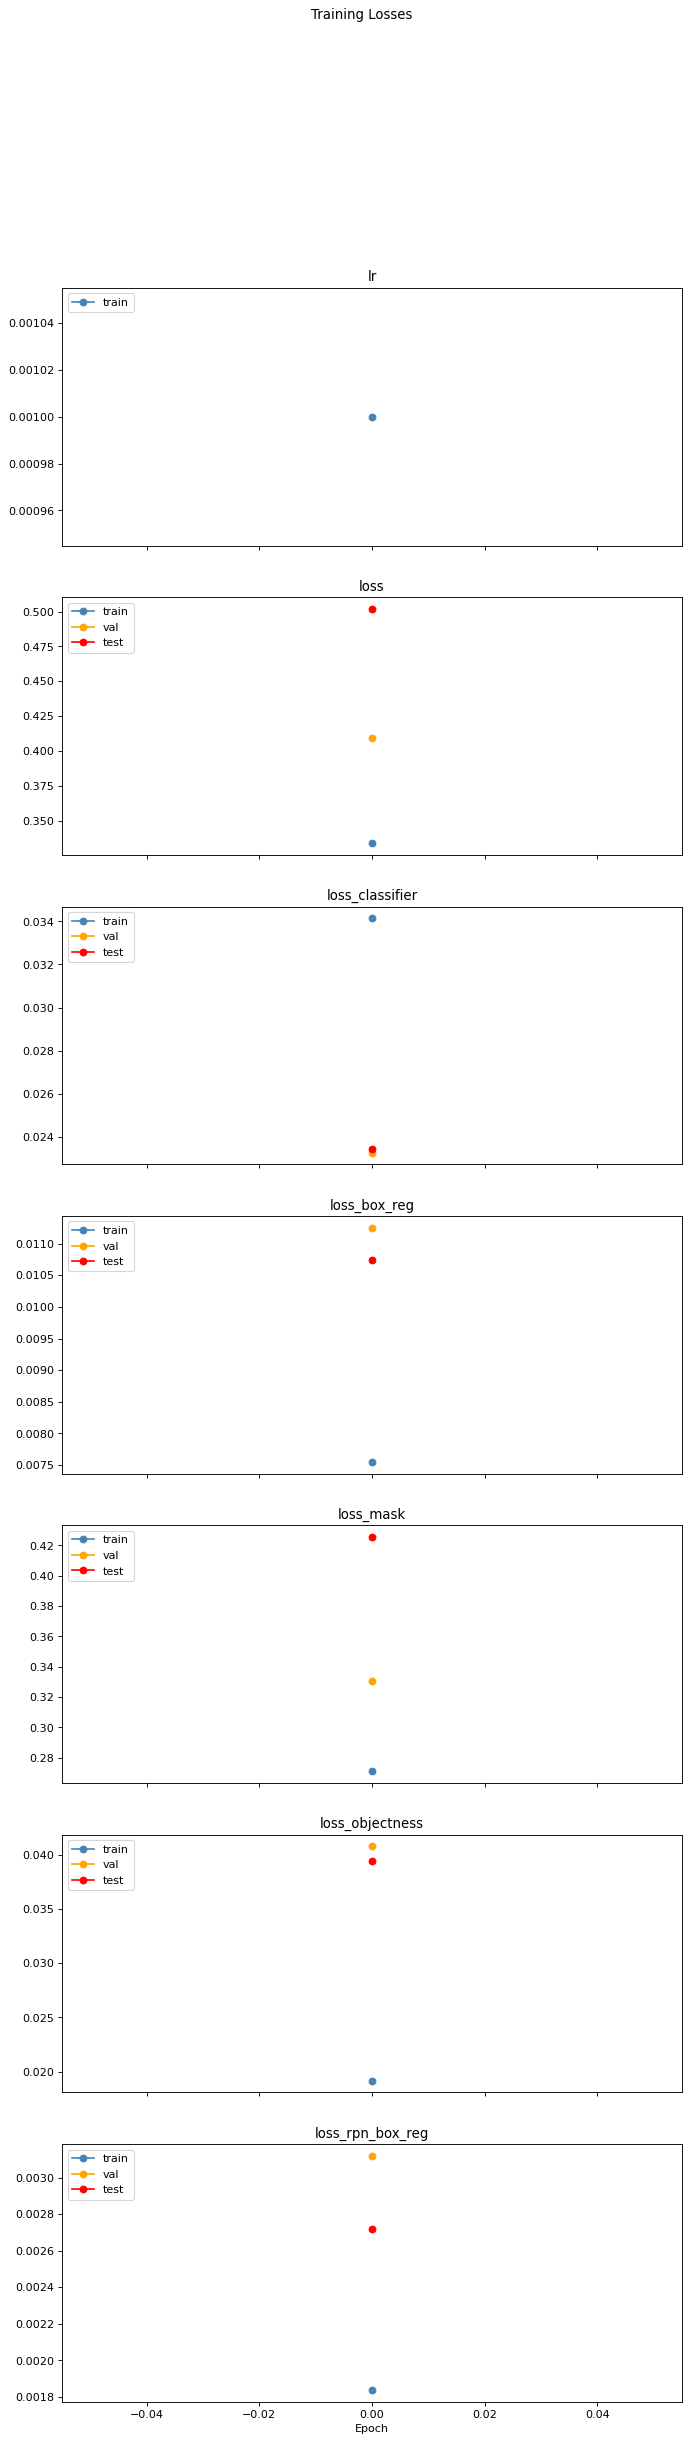

In [8]:
for train_info in train_infos:
    print(train_info)
    model_setup = train_info.model_setup
    model = create_multimodal_rcnn_model(
        labels_cols,
        model_setup,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    print_params_setup(model)
    print(f"Max AP on test: [{max([ap_ar['ap']  for ap_ar in  train_info.test_ap_ars]):.4f}]")
    plot_ap_ars(
            train_ap_ars=train_info.train_ap_ars,
            val_ap_ars=train_info.val_ap_ars,
            test_ap_ars=train_info.test_ap_ars,
        )

    plot_losses(train_info.train_losses, train_info.val_losses, test_logers=train_info.test_losses)

